In [1]:
!pip install tensorflow keras scikit-learn opencv-python matplotlib numpy tqdm pandas

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Lambda, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
base_dir = r"C:\Users\27677\Downloads\archive\lfw-deepfunneled\lfw-deepfunneled"
csv_dir = r"C:\Users\27677\Downloads\archive"
train_match = os.path.join(csv_dir, "matchpairsDevTrain.csv")
train_mismatch = os.path.join(csv_dir, "mismatchpairsDevTrain.csv")
test_match = os.path.join(csv_dir, "matchpairsDevTest.csv")
test_mismatch = os.path.join(csv_dir, "mismatchpairsDevTest.csv")

In [4]:
def get_image_path(name, num):
    return os.path.join(base_dir, f"{name}/{name}_{int(num):04d}.jpg")

def load_image(path, size=(100,100)):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    img = img / 255.0
    return img

In [6]:
#ResNet50 Embedding model
input_shape = (100,100,3)
base_cnn = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
base_cnn.trainable = False

x = GlobalAveragePooling2D()(base_cnn.output)
x = Dense(256, activation='relu')(x)
embedding_output = Dense(128)(x)
embedding_output = Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(embedding_output)
embedding_model = Model(base_cnn.input, embedding_output, name="embedding_model")
embedding_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step



Model: "embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_3_c

 Total params: 24,145,152 (92.11 MB)

 Trainable params: 557,440 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
def generate_hard_negatives(embedding_model, df, size=(100,100), top_k=2):
    X1, X2, y = [], [], []

    images = {}
    embeddings = {}
    for _, row in df.iterrows():
        for col_name, col_person in [('imagenum1', 'name'), ('imagenum2', 'name')]:
            key = f"{row[col_person]}_{row[col_name]}"
            if key not in images:
                path = get_image_path(row[col_person], row[col_name])
                img = load_image(path, size)
                if img is not None:
                    images[key] = img
                    embeddings[key] = embedding_model(np.expand_dims(img, axis=0), training=False)[0].numpy()


    # Positive pairs
    for _, row in df.iterrows():
        p1 = f"{row['name']}_{row['imagenum1']}"
        p2 = f"{row['name']}_{row['imagenum2']}"
        if p1 in images and p2 in images:
            X1.append(images[p1])
            X2.append(images[p2])
            y.append(1)

    # Hard negative pairs
    keys = list(embeddings.keys())
    for key_a in keys:
        anchor_emb = embeddings[key_a]
        sims = []
        for key_b in keys:
            if key_a.split("_")[0] != key_b.split("_")[0]:  # different person
                other_emb = embeddings[key_b]
                cosine_sim = np.dot(anchor_emb, other_emb) / (np.linalg.norm(anchor_emb) * np.linalg.norm(other_emb))
                sims.append((cosine_sim, key_b))
        sims.sort(reverse=True)
        for i in range(min(top_k, len(sims))):
            hard_neg = sims[i][1]
            X1.append(images[key_a])
            X2.append(images[hard_neg])
            y.append(0)

    return np.array(X1), np.array(X2), np.array(y)

In [16]:
#Loading the Data
train_df = pd.concat([
    pd.read_csv(train_match),
    pd.read_csv(train_mismatch)
], ignore_index=True)

test_df = pd.concat([
    pd.read_csv(test_match),
    pd.read_csv(test_mismatch)
], ignore_index=True)

train_X1, train_X2, train_y = generate_hard_negatives(embedding_model, train_df, size=(100,100), top_k=2)
test_X1, test_X2, test_y = generate_hard_negatives(embedding_model, test_df, size=(100,100), top_k=2)

print("Train Shapes:", train_X1.shape, train_X2.shape, train_y.shape)
print("Test Shapes:", test_X1.shape, test_X2.shape, test_y.shape)

Train Shapes: (7702, 100, 100, 3) (7702, 100, 100, 3) (7702,)
Test Shapes: (3496, 100, 100, 3) (3496, 100, 100, 3) (3496,)


In [19]:
#SNN with ArcFace
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

emb_a = embedding_model(input_a)
emb_b = embedding_model(input_b)

#use Keras Lambda layers
cosine = Lambda(lambda x: tf.reduce_sum(x[0] * x[1], axis=1, keepdims=True))([emb_a, emb_b])
cosine = Lambda(lambda x: tf.clip_by_value(x, -1.0 + 1e-7, 1.0 - 1e-7))(cosine)
theta = Lambda(lambda x: tf.acos(x))(cosine)
cosine_margin = Lambda(lambda x: tf.cos(x + 0.5))(theta)
output = Lambda(lambda x: (x + 1) / 2)(cosine_margin)

snn = Model(inputs=[input_a, input_b], outputs=output)


In [20]:
def arcface_loss(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(y_true * tf.square(1 - y_pred) + (1 - y_true) * tf.square(y_pred))

snn.compile(loss=arcface_loss, optimizer='adam', metrics=['accuracy'])
snn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_model     │ (None, 128)       │ 24,145,152 │ input_layer_5[0]… │
│ (Functional)        │                   │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1)         │          0 │ embedding_model[… │
│                     │                   │            │ embedding_model[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 1)         │          0 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 1)         │          0 │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 1)         │          0 │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 1)         │          0 │ lambda_6[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,145,152 (92.11 MB)

 Trainable params: 557,440 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
#callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)]

In [23]:
history = snn.fit(
    [train_X1, train_X2],
    train_y,
    validation_data=([test_X1, test_X2], test_y),
    epochs=15,
    batch_size=32,
    callbacks=callbacks)

Epoch 1/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.3177 - loss: 0.5065 - val_accuracy: 0.3064 - val_loss: 0.5424 - learning_rate: 0.0010
Epoch 2/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 236s 981ms/step - accuracy: 0.3191 - loss: 0.5142 - val_accuracy: 0.3587 - val_loss: 0.4693 - learning_rate: 0.0010
Epoch 3/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 262s 982ms/step - accuracy: 0.3454 - loss: 0.4859 - val_accuracy: 0.3287 - val_loss: 0.5022 - learning_rate: 0.0010
Epoch 4/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.3268 - loss: 0.5440 - val_accuracy: 0.2674 - val_loss: 0.6414 - learning_rate: 0.0010
Epoch 5/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.3619 - loss: 0.4735 - val_accuracy: 0.3976 - val_loss: 0.4251 - learning_rate: 0.0010
Epoch 6/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.3956 - loss: 0.4395 - val_accuracy: 0.4090 - val_loss: 0.4309 - learning_rate: 0.0010
Epoch 7/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.4125 - lo

110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 397ms/step
Optimal Threshold: 0.937
Accuracy: 0.832
Precision: 0.946
Recall: 0.392
F1 Score: 0.554
AUC: 0.650
Confusion Matrix:
 [[2543   21]
 [ 567  365]]


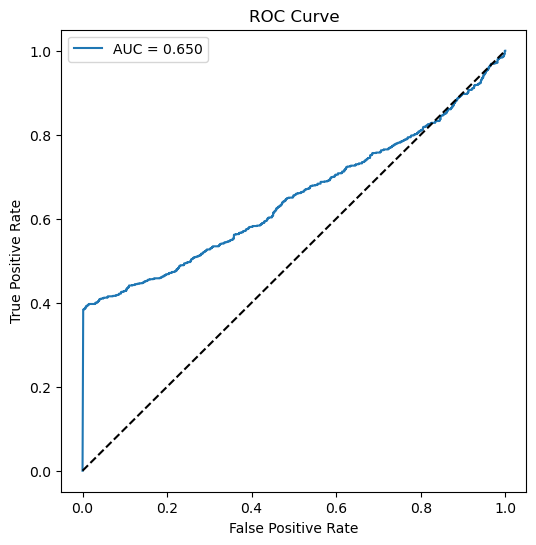

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# ------------------------
# --- Model Predictions ---
# ------------------------
pred_snn = snn.predict([test_X1, test_X2], batch_size=32).flatten()  # get predictions
# Scale is already [0,1] if you used Lambda, otherwise normalize here:
# pred_snn = (pred_snn + 1) / 2

# ------------------------
# --- Optimal Threshold via ROC ---
# ------------------------
fpr, tpr, thresholds = roc_curve(test_y, pred_snn)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.3f}")

# Convert probabilities to binary labels
pred_labels_opt = (pred_snn >= optimal_threshold).astype(int)

# ------------------------
# --- Metrics ---
# ------------------------
acc = accuracy_score(test_y, pred_labels_opt)
prec = precision_score(test_y, pred_labels_opt)
rec = recall_score(test_y, pred_labels_opt)
f1 = f1_score(test_y, pred_labels_opt)
auc = roc_auc_score(test_y, pred_snn)
cm = confusion_matrix(test_y, pred_labels_opt)

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC: {auc:.3f}")
print("Confusion Matrix:\n", cm)

# ------------------------
# --- ROC Curve Plot ---
# ------------------------
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model

# --- Create baseline CNN ---
def build_baseline_cnn(input_shape=(100, 100, 3)):
    # First input
    input_1 = Input(shape=input_shape)
    x1 = Conv2D(32, (3,3), activation='relu', padding='same')(input_1)
    x1 = MaxPooling2D(2)(x1)
    x1 = Conv2D(64, (3,3), activation='relu', padding='same')(x1)
    x1 = MaxPooling2D(2)(x1)
    x1 = Flatten()(x1)

    # Second input
    input_2 = Input(shape=input_shape)
    x2 = Conv2D(32, (3,3), activation='relu', padding='same')(input_2)
    x2 = MaxPooling2D(2)(x2)
    x2 = Conv2D(64, (3,3), activation='relu', padding='same')(x2)
    x2 = MaxPooling2D(2)(x2)
    x2 = Flatten()(x2)

    # Combine both feature vectors
    combined = Concatenate()([x1, x2])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.3)(combined)
    output = Dense(1, activation='sigmoid')(combined)

    model = Model(inputs=[input_1, input_2], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate and train
baseline_cnn = build_baseline_cnn()

baseline_history = baseline_cnn.fit(
    [train_X1, train_X2], train_y,
    validation_data=([test_X1, test_X2], test_y),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.7351 - loss: 0.6036 - val_accuracy: 0.7337 - val_loss: 0.5749
Epoch 2/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.7375 - loss: 0.5698 - val_accuracy: 0.7348 - val_loss: 0.5603
Epoch 3/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.7425 - loss: 0.5540 - val_accuracy: 0.7208 - val_loss: 0.5849
Epoch 4/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.7511 - loss: 0.5382 - val_accuracy: 0.7366 - val_loss: 0.5640
Epoch 5/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 231s 958ms/step - accuracy: 0.7632 - loss: 0.5124 - val_accuracy: 0.7357 - val_loss: 0.5595


In [52]:
pred_cnn = baseline_cnn.predict([test_X1, test_X2]).flatten()

# Threshold at 0.5 for binary prediction
pred_cnn_labels = (pred_cnn >= 0.5).astype(int)

# Compute metrics
acc_cnn = accuracy_score(test_y, pred_cnn_labels)
prec_cnn = precision_score(test_y, pred_cnn_labels)
rec_cnn = recall_score(test_y, pred_cnn_labels)
f1_cnn = f1_score(test_y, pred_cnn_labels)
auc_cnn = roc_auc_score(test_y, pred_cnn)

print("\n--- Baseline CNN Results ---")
print(f"Accuracy: {acc_cnn:.3f}")
print(f"Precision: {prec_cnn:.3f}")
print(f"Recall: {rec_cnn:.3f}")
print(f"F1 Score: {f1_cnn:.3f}")
print(f"AUC: {auc_cnn:.3f}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 33s 294ms/step

--- Baseline CNN Results ---
Accuracy: 0.736
Precision: 0.514
Recall: 0.158
F1 Score: 0.241
AUC: 0.646


In [57]:
print("\n===== MODEL COMPARISON =====")
print(f"{'Metric':<15}{'SNN':<10}{'CNN':<10}")
print(f"{'Accuracy':<15}{acc:.3f}{'':<5}{acc_cnn:.3f}")
print(f"{'Precision':<15}{prec:.3f}{'':<5}{prec_cnn:.3f}")
print(f"{'Recall':<15}{rec:.3f}{'':<5}{rec_cnn:.3f}")
print(f"{'F1 Score':<15}{f1:.3f}{'':<5}{f1_cnn:.3f}")
print(f"{'AUC':<15}{auc:.3f}{'':<5}{auc_cnn:.3f}")


===== MODEL COMPARISON =====
Metric         SNN       CNN       
Accuracy       0.832     0.736
Precision      0.946     0.514
Recall         0.392     0.158
F1 Score       0.554     0.241
AUC            0.650     0.646


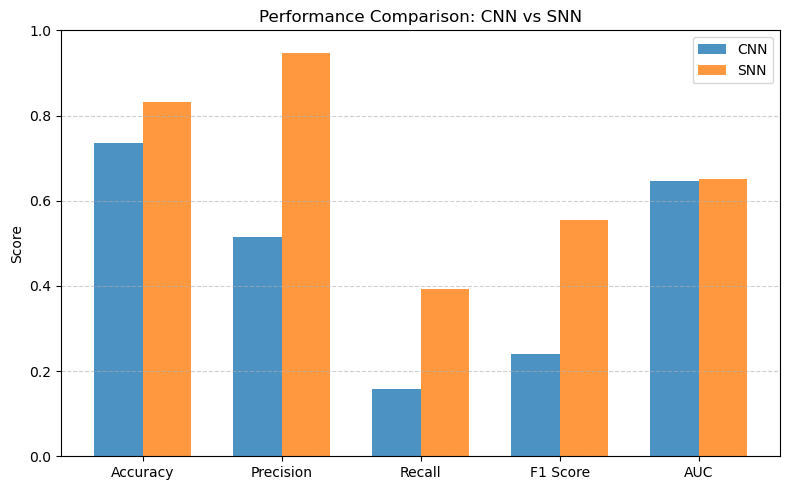

In [58]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
cnn_scores = [0.736, 0.514, 0.158, 0.241, 0.646]
snn_scores = [0.832, 0.946, 0.392, 0.554, 0.65]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, cnn_scores, width, label='CNN', alpha=0.8)
plt.bar(x + width/2, snn_scores, width, label='SNN', alpha=0.8)
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.title('Performance Comparison: CNN vs SNN')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [59]:
import pickle
import json
from tensorflow.keras.models import save_model

# === 1. Save the trained model ===
snn.save("snn_full_model.h5")
print("✅ Siamese model saved successfully as snn_full_model.h5")

# === 2. Save training history ===
with open("snn_training_history.json", "w") as f:
    json.dump(history.history, f)
print("✅ Training history saved as snn_training_history.json")

# === 3. Save label encoders or preprocessing objects (if any) ===
# Example: if you used LabelEncoder or scalers
# pickle.dump(label_encoder, open("label_encoder.pkl", "wb"))

# === 4. Save dataset splits or meta info (optional) ===
metadata = {
    "input_shape": (100, 100, 3),
    "epochs": 15,
    "batch_size": 32,
    "model_type": "Siamese Neural Network (ResNet50 base)",
    "note": "Full training environment snapshot"
}
with open("snn_metadata.json", "w") as f:
    json.dump(metadata, f)
print("✅ Metadata saved as snn_metadata.json")

# === 5. Zip everything for portability (optional) ===
import shutil
shutil.make_archive("snn_project_backup", "zip", ".")
print("✅ Everything packaged into snn_project_backup.zip")


✅ Siamese model saved successfully as snn_full_model.h5
✅ Training history saved as snn_training_history.json
✅ Metadata saved as snn_metadata.json


PermissionError: [Errno 13] Permission denied: 'NTUSER.DAT'

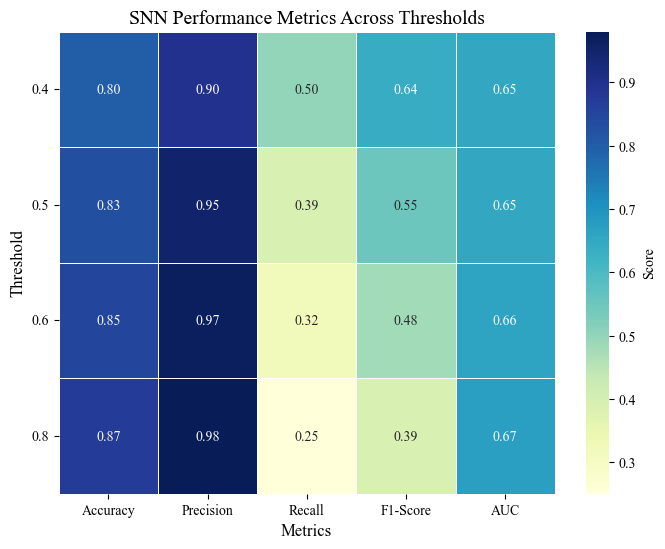

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = {
    'Accuracy': [0.80, 0.83, 0.85, 0.87],
    'Precision': [0.90, 0.95, 0.97, 0.98],
    'Recall': [0.50, 0.39, 0.32, 0.25],
    'F1-Score': [0.64, 0.55, 0.48, 0.39],
    'AUC': [0.65, 0.65, 0.66, 0.67]
}

thresholds = [0.4, 0.5, 0.6, 0.8]

df = pd.DataFrame(data, index=thresholds)

# Set Times New Roman globally
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Score'}, linewidths=0.5)
plt.title("SNN Performance Metrics Across Thresholds", fontsize=14)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Threshold", fontsize=12)
plt.yticks(rotation=0)
plt.show()

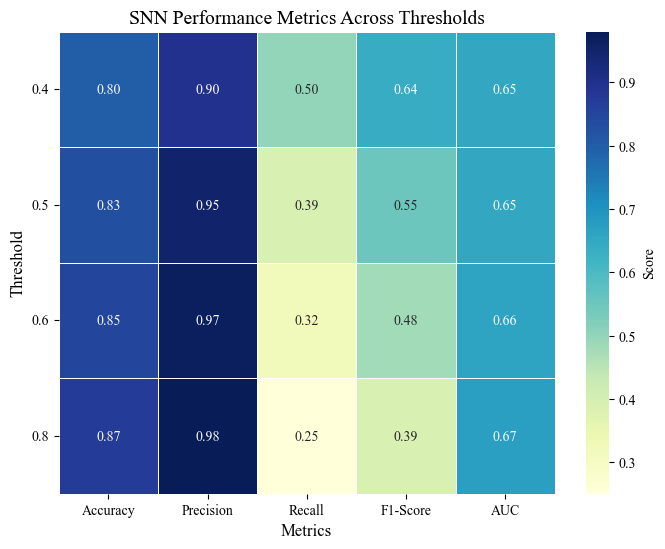

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = {
    'Accuracy': [0.80, 0.83, 0.85, 0.87],
    'Precision': [0.90, 0.95, 0.97, 0.98],
    'Recall': [0.50, 0.39, 0.32, 0.25],
    'F1-Score': [0.64, 0.55, 0.48, 0.39],
    'AUC': [0.65, 0.65, 0.66, 0.67]
}

thresholds = [0.4, 0.5, 0.6, 0.8]

df = pd.DataFrame(data, index=thresholds)

# Set Times New Roman globally
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Score'}, linewidths=0.5)
plt.title("SNN Performance Metrics Across Thresholds", fontsize=14)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Threshold", fontsize=12)
plt.yticks(rotation=0)
plt.show()

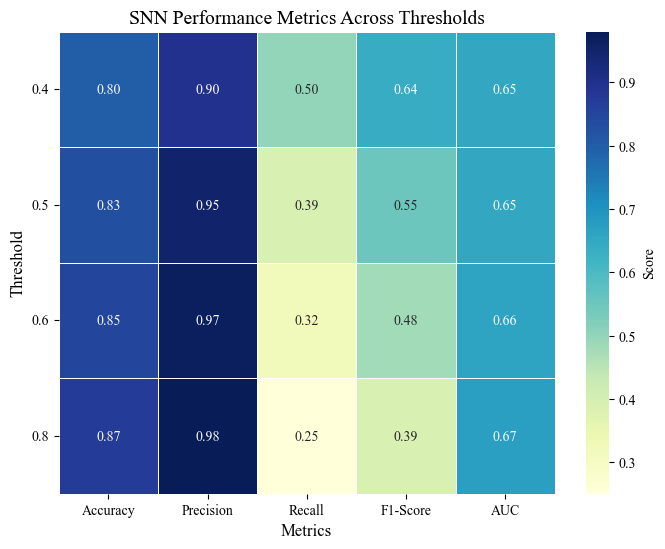

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = {
    'Accuracy': [0.80, 0.83, 0.85, 0.87],
    'Precision': [0.90, 0.95, 0.97, 0.98],
    'Recall': [0.50, 0.39, 0.32, 0.25],
    'F1-Score': [0.64, 0.55, 0.48, 0.39],
    'AUC': [0.65, 0.65, 0.66, 0.67]
}

thresholds = [0.4, 0.5, 0.6, 0.8]

df = pd.DataFrame(data, index=thresholds)

# Set Times New Roman globally
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Score'}, linewidths=0.5)
plt.title("SNN Performance Metrics Across Thresholds", fontsize=14)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Threshold", fontsize=12)
plt.yticks(rotation=0)
plt.show()